In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

#IMG_HEIGHT = 260
#IMG_WIDTH = 200
#IMG_HEIGHT = 224
#IMG_WIDTH = 224
IMG_HEIGHT = 32
IMG_WIDTH = 32

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

In [3]:
train_df.head()

,img_name,img_height,img_width,img_ratio,num_channels,superhero,img_path
0,cax_antman_train1.jpg,216,233,0.927039,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
1,cax_antman_train10.jpg,230,210,1.095238,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
2,cax_antman_train100.jpg,225,225,1.000000,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
3,cax_antman_train101.jpg,251,201,1.248756,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
4,cax_antman_train102.jpg,225,225,1.000000,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...


<Container object of 12 artists>

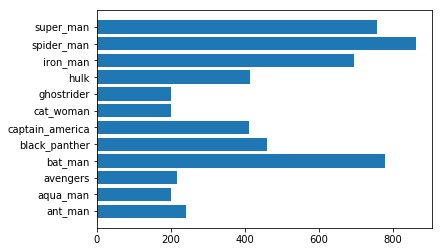

In [4]:
plt.barh(train_df['superhero'].value_counts().index,train_df['superhero'].value_counts().values)

In [5]:
labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

In [7]:
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

In [8]:
transform_data = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor()])

In [9]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [10]:
train_set = SuperheroesDataset(x_train, y_train, transform_data)
train_load = DataLoader(train_set,batch_size=64)

In [11]:
valid_set = SuperheroesDataset(x_valid, y_valid, transform_data)
valid_load = DataLoader(valid_set,batch_size=64)

In [12]:
test_set = SuperheroesDataset(x_test, y_test, transform_data)
test_load = DataLoader(test_set,batch_size=1)

In [13]:
image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [33]:
torch.random.manual_seed(12345)
model_ft.apply(reset)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2118 Acc: 0.2384
val Loss: 1.9643 Acc: 0.3275

Epoch 1/24
----------
train Loss: 1.8420 Acc: 0.4017
val Loss: 1.8499 Acc: 0.4039

Epoch 2/24
----------
train Loss: 1.6485 Acc: 0.4680
val Loss: 1.6749 Acc: 0.4655

Epoch 3/24
----------
train Loss: 1.5204 Acc: 0.5055
val Loss: 1.5150 Acc: 0.4977

Epoch 4/24
----------
train Loss: 1.4288 Acc: 0.5320
val Loss: 1.5654 Acc: 0.5097

Epoch 5/24
----------
train Loss: 1.2924 Acc: 0.5812
val Loss: 1.3275 Acc: 0.5731

Epoch 6/24
----------
train Loss: 1.2462 Acc: 0.5966
val Loss: 1.3112 Acc: 0.5777

Epoch 7/24
----------
train Loss: 1.2202 Acc: 0.6049
val Loss: 1.3016 Acc: 0.5823

Epoch 8/24
----------
train Loss: 1.1969 Acc: 0.6134
val Loss: 1.2927 Acc: 0.5833

Epoch 9/24
----------
train Loss: 1.1745 Acc: 0.6217
val Loss: 1.2852 Acc: 0.5842

Epoch 10/24
----------
train Loss: 1.1522 Acc: 0.6307
val Loss: 1.2801 Acc: 0.5851

Epoch 11/24
----------
train Loss: 1.1299 Acc: 0.6387
val Loss: 1.2751 Acc: 0.5879

Ep

In [37]:
torch.save(model_ft, 'model_ft')

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(labelencoder_dic[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

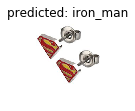

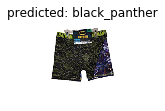

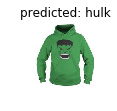

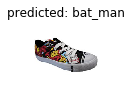

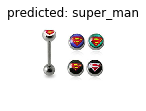

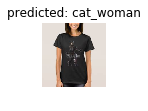

In [43]:
visualize_model(model_ft)

#### ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [46]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [47]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2218 Acc: 0.2609
val Loss: 1.9052 Acc: 0.4085

Epoch 1/24
----------
train Loss: 1.7560 Acc: 0.4581
val Loss: 1.6328 Acc: 0.4959

Epoch 2/24
----------
train Loss: 1.5422 Acc: 0.5290
val Loss: 1.4891 Acc: 0.5428

Epoch 3/24
----------
train Loss: 1.4138 Acc: 0.5699
val Loss: 1.3989 Acc: 0.5667

Epoch 4/24
----------
train Loss: 1.3254 Acc: 0.5946
val Loss: 1.3365 Acc: 0.5888

Epoch 5/24
----------
train Loss: 1.2596 Acc: 0.6091
val Loss: 1.2907 Acc: 0.6044

Epoch 6/24
----------
train Loss: 1.2079 Acc: 0.6243
val Loss: 1.2554 Acc: 0.6127

Epoch 7/24
----------
train Loss: 1.1704 Acc: 0.6385
val Loss: 1.2362 Acc: 0.6237

Epoch 8/24
----------
train Loss: 1.1609 Acc: 0.6429
val Loss: 1.2327 Acc: 0.6283

Epoch 9/24
----------
train Loss: 1.1568 Acc: 0.6434
val Loss: 1.2298 Acc: 0.6293

Epoch 10/24
----------
train Loss: 1.1529 Acc: 0.6447
val Loss: 1.2269 Acc: 0.6311

Epoch 11/24
----------
train Loss: 1.1491 Acc: 0.6473
val Loss: 1.2242 Acc: 0.6320

Ep

In [48]:
torch.save(model_ft, 'model_conv')

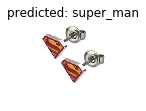

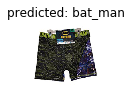

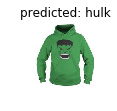

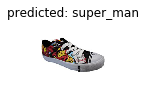

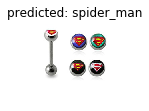

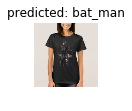

In [49]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [17]:
model_conv = torch.load('model_conv')

In [18]:
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        #preds = preds.cpu().numpy()[0]           #convert from tensor to numpy and get 1 number 
        predictions.append(preds[0])
        
    return predictions

In [19]:
predictions = predict(test_load, model_conv)

100%|█████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:32<00:00, 104.66it/s]


In [20]:
predictions[:5]

[10, 11, 10, 10, 4]

In [174]:
labelencoder_dic

{0: 'ant_man',
 1: 'aqua_man',
 2: 'avengers',
 3: 'bat_man',
 4: 'black_panther',
 5: 'captain_america',
 6: 'cat_woman',
 7: 'ghostrider',
 8: 'hulk',
 9: 'iron_man',
 10: 'spider_man',
 11: 'super_man'}

In [21]:
d = {'filename': test_df['img_name'], 'Superhero': predictions}

In [22]:
predict_df = pd.DataFrame(d)

In [23]:
predict_df = predict_df[['filename', 'Superhero']]

In [24]:
predict_df.head()

,filename,Superhero
0,superhero_test_1.jpg,10
1,superhero_test_10.jpg,11
2,superhero_test_100.jpg,10
3,superhero_test_1000.jpg,10
4,superhero_test_1001.jpg,4


In [25]:
predict_df['filename'] = predict_df['filename'].map(lambda x: str(x)[:-4])

In [26]:
predict_df.replace({"Superhero": labelencoder_dic}, inplace=True)

In [27]:
predict_df.head()

,filename,Superhero
0,superhero_test_1,spider_man
1,superhero_test_10,super_man
2,superhero_test_100,spider_man
3,superhero_test_1000,spider_man
4,superhero_test_1001,black_panther


In [49]:
submission = pd.read_csv('data/Superhero_3375_SampleSubmission.csv')

In [51]:
submission.head()

,filename,Superhero
0,superhero_test_1,ant_man
1,superhero_test_2,super_man
2,superhero_test_3,iron_man
3,superhero_test_4,bat_man
4,superhero_test_5,captain_america


In [52]:
# find filename in predict and insert superhero in submission
for i in tqdm(range(submission.shape[0])):
    filename = submission['filename'].iloc[i]
    submission['Superhero'].iloc[i] = predict_df['Superhero'][predict_df['filename'] == filename].values[0]

100%|████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:02<00:00, 1480.11it/s]


In [55]:
submission.head()

,filename,Superhero
0,superhero_test_1,spider_man
1,superhero_test_2,super_man
2,superhero_test_3,iron_man
3,superhero_test_4,bat_man
4,superhero_test_5,captain_america


In [56]:
submission.to_csv('submit.csv', index=False)

In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
image_datasets = datasets.ImageFolder(TRAIN_PATH, data_transforms)

image_dataloader = DataLoader(image_datasets, batch_size=5, shuffle=True)

dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

#use_gpu = torch.cuda.is_available()
use_gpu = False

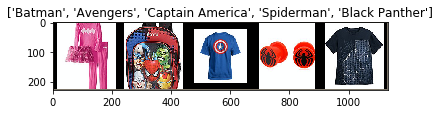

In [37]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(image_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [38]:
classes


  3
  2
  5
 10
  4
[torch.LongTensor of size 5]

In [100]:
classes


  5
  9
  8
 10
  9
[torch.LongTensor of size 5]

In [101]:
image_datasets.classes

['Ant-Man',
 'Aquaman',
 'Avengers',
 'Batman',
 'Black Panther',
 'Captain America',
 'Catwoman',
 'Ghost Rider',
 'Hulk',
 'Iron Man',
 'Spiderman',
 'Superman']

In [93]:
next(iter(image_dataloader))

[
 ( 0 , 0 ,.,.) = 
   2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
   2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
   2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
            ...             ⋱             ...          
   2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
   2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
   2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
 
 ( 0 , 1 ,.,.) = 
   2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
   2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
   2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
            ...             ⋱             ...          
   2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
   2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
   2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
 
 ( 0 , 2 ,.,.) = 
   2.6400  2.6400  2.6400  ...   2.6400  2.6400  2.6400
   2.6400  2.6400  2.6400  ...   2.6400  2.6400  2.6400
   2.6400  2.6400  2.6400  ...   2.6400  2.6